In [1]:
import sys
import os

%load_ext autoreload
%autoreload 2

sys.path.append('../')
sys.path.insert(0, os.path.dirname(os.getcwd()) + "/../")

print(sys.path)

['/home/hieutt/electricity_theft_detection/../', '/home/hieutt/electricity_theft_detection/notebooks', '/home/hieutt/miniconda3/envs/torchtf/lib/python39.zip', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/lib-dynload', '', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/site-packages', '../']


In [5]:
# ===== STEP 1: Load benign & define attacks =====
import os
import numpy as np
import pandas as pd

# ---------- Load từ thư mục CER (id, slot, kwh) → (N,24) ----------
def load_halfhour_txt(path):
    return pd.read_csv(path, sep=r"\s+", header=None, names=["id", "slot", "kwh"])

def halfhour_to_hourly(df_one_id):
    df_one_id = df_one_id.sort_values('slot')
    base = df_one_id['slot'].min()
    hour_idx = ((df_one_id['slot'] - base) // 2).astype(int)
    hh = (df_one_id
          .assign(hour_idx=hour_idx)
          .groupby('hour_idx', as_index=False)['kwh']
          .mean())
    return hh  # columns: hour_idx, kwh

def hourly_to_daily_24(hh):
    hh = hh.sort_values('hour_idx')
    day_idx = (hh['hour_idx'] // 24).to_numpy()
    hour_in_day = (hh['hour_idx'] % 24).to_numpy()
    kwh = hh['kwh'].to_numpy()

    days = {}
    for d, h, v in zip(day_idx, hour_in_day, kwh):
        days.setdefault(d, np.full(24, np.nan, dtype=float))
        days[d][h] = v

    X = []
    for d in sorted(days.keys()):
        vec = days[d]
        if np.isfinite(vec).sum() == 24:
            X.append(vec.astype(float))
    if not X:
        return np.empty((0, 24), dtype=float)
    return np.stack(X, axis=0)

def build_benign_from_folder(folder):
    all_benign = []
    for fname in sorted(os.listdir(folder)):
        if not fname.lower().endswith('.txt'):
            continue
        df = load_halfhour_txt(os.path.join(folder, fname))
        for cid, g in df.groupby('id'):
            hh = halfhour_to_hourly(g[['slot', 'kwh']].copy())
            X = hourly_to_daily_24(hh)
            if len(X) > 0:
                all_benign.append(X)
    if not all_benign:
        return np.empty((0, 24), dtype=float)
    return np.vstack(all_benign)

# ---------- 6 loại attack (theo bài báo) ----------
_rng_global = np.random.default_rng(42)

def atk_h1_scale_down(x, a=None, rng=None):
    """h1: x' = α x, α ∈ [0.1, 0.8]"""
    rng = _rng_global if rng is None else rng
    if a is None: a = rng.uniform(0.1, 0.8)
    return a * x

def atk_h2_zero_random_hours(x, n_zero=None, rng=None):
    """h2: đặt 0 ở một số giờ ngẫu nhiên (3..8 giờ)"""
    rng = _rng_global if rng is None else rng
    x2 = x.copy()
    if n_zero is None:
        n_zero = int(rng.integers(3, 9))
    idx = rng.choice(24, size=n_zero, replace=False)
    x2[idx] = 0.0
    return x2

def atk_h3_rand_scale_per_hour(x, rng=None):
    """h3: mỗi giờ nhân hệ số ngẫu nhiên (0.1..0.8)"""
    rng = _rng_global if rng is None else rng
    gamma = rng.uniform(0.1, 0.8, size=24)
    return gamma * x

def atk_h4_mean_scaled(x, rng=None):
    """h4: thay toàn bộ bằng mean(x) * γ_t, γ_t ∈ [0.1,0.8]"""
    rng = _rng_global if rng is None else rng
    mu = x.mean()
    gamma = rng.uniform(0.1, 0.8, size=24)
    return gamma * mu

def atk_h5_mean_flat(x):
    """h5: thay toàn bộ bằng mean(x) (đường phẳng)"""
    mu = x.mean()
    return np.full(24, mu, dtype=float)

def atk_h6_reverse_day(x):
    """h6: đảo 24 giờ (load shifting)"""
    return x[::-1].copy()

ATK_FUNCS = {
    1: atk_h1_scale_down,
    2: atk_h2_zero_random_hours,
    3: atk_h3_rand_scale_per_hour,
    4: atk_h4_mean_scaled,
    5: atk_h5_mean_flat,
    6: atk_h6_reverse_day,
}

# ---------- Hàm sinh attacks từ benign + gán nhãn ----------
def make_attacks_from_benign(
    X_benign,
    attack_types=(1,2,3,4,5,6),
    per_attack=1,
    benign_limit=None,
    benign_frac=None,
    seed=42
):
    """
    Trả:
      X_all: (M,24) float32
      y_all: (M,)   int64  (0=benign, 1=attack)
      t_all: (M,)   int16  (0=benign, 1..6=loại attack)
      info : dict   (thông tin đếm)
    """
    rng = np.random.default_rng(seed)
    X_benign = np.asarray(X_benign, dtype=np.float32)
    N = len(X_benign)

    # chọn subset benign để sinh (nếu cần)
    if benign_frac is not None:
        assert 0 < benign_frac <= 1.0
        benign_limit = int(round(N * benign_frac))
    if benign_limit is not None:
        benign_limit = min(int(benign_limit), N)
        idx_sub = rng.choice(N, size=benign_limit, replace=False)
        X_used = X_benign[idx_sub]
    else:
        X_used = X_benign
    n_used = len(X_used)

    # benign giữ nguyên
    X_list = [X_used]
    y_list = [np.zeros(n_used, dtype=np.int64)]
    t_list = [np.zeros(n_used, dtype=np.int16)]

    # attacks
    counts_by_type = {}
    for atk_id in attack_types:
        fn = ATK_FUNCS[atk_id]
        outs = []
        for _ in range(int(per_attack)):
            # per-sample apply
            A = np.vstack([fn(x, rng=np.random.default_rng(rng.integers(1<<30)))
                           if fn in (atk_h1_scale_down, atk_h2_zero_random_hours, atk_h3_rand_scale_per_hour, atk_h4_mean_scaled)
                           else fn(x)
                           for x in X_used])
            outs.append(A.astype(np.float32, copy=False))
        A_all = np.vstack(outs) if outs else np.empty((0,24), dtype=np.float32)
        counts_by_type[atk_id] = len(A_all)
        X_list.append(A_all)
        y_list.append(np.ones(len(A_all), dtype=np.int64))
        t_list.append(np.full(len(A_all), atk_id, dtype=np.int16))

    X_all = np.concatenate(X_list, axis=0).astype(np.float32, copy=False)
    y_all = np.concatenate(y_list, axis=0).astype(np.int64, copy=False)
    t_all = np.concatenate(t_list, axis=0).astype(np.int16, copy=False)

    info = {
        'N_used': n_used,
        'attack_types_chosen': tuple(attack_types),
        'counts_by_type': counts_by_type,
        'rng_seed': seed,
    }
    return X_all, y_all, t_all, info

# ---- RUN (step 1) ----
folder = '../data/CER_ETD'   # đổi đường dẫn nếu cần
X_benign = build_benign_from_folder(folder)
print('Benign days pool:', X_benign.shape)  # (N_benign_all, 24)

# Ví dụ: sinh tất cả 6 loại attack với per_attack=1 trên 20% benign
X_all_raw, y_all_raw, t_all_raw, info_raw = make_attacks_from_benign(
    X_benign, per_attack=1, benign_frac=0.2, attack_types=(1,2,3,4,5,6), seed=2025
)
print('Info (step1):', info_raw)
print('All (raw):', X_all_raw.shape, y_all_raw.shape, t_all_raw.shape)


Benign days pool: (276630, 24)
Info (step1): {'N_used': 55326, 'attack_types_chosen': (1, 2, 3, 4, 5, 6), 'counts_by_type': {1: 55326, 2: 55326, 3: 55326, 4: 55326, 5: 55326, 6: 55326}, 'rng_seed': 2025}
All (raw): (387282, 24) (387282,) (387282,)


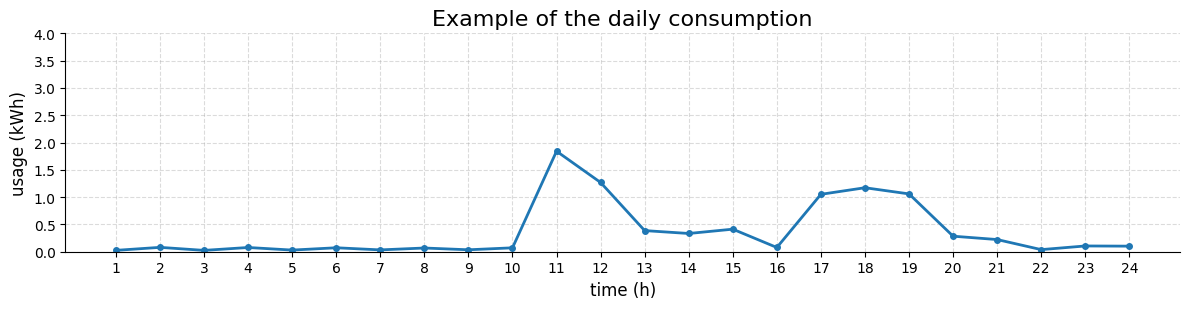

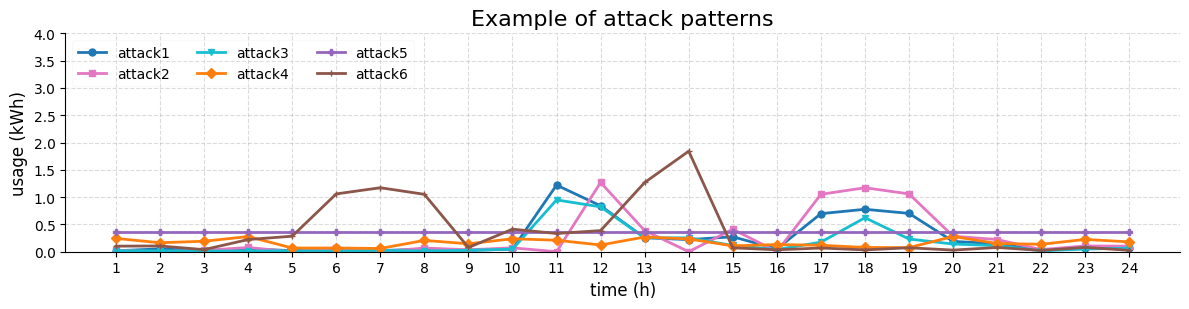

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# ====== cấu hình style gần giống hình mẫu ======
plt.rcParams.update({
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.45,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlesize": 16,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# ====== chọn ngày theo index có sẵn ======
sample_idx = 1                 # <-- đổi index bạn muốn
x_day = np.asarray(X_benign[sample_idx], dtype=float)
hours = np.arange(1, 25)

# Đặt trục y cho đẹp (0..4 kWh, hoặc theo max của ngày)
ylim_top = max(4.0, float(np.ceil(max(x_day.max(), 1.0) / 0.5) * 0.5))
yticks = np.arange(0.0, ylim_top + 1e-6, 0.5)

# ====== Figure 1: benign ======
plt.figure(figsize=(12,3.2))
plt.plot(hours, x_day, color="#1f77b4", marker="o", markersize=4, linewidth=2)
plt.title("Example of the daily consumption")
plt.xlabel("time (h)")
plt.ylabel("usage (kWh)")
plt.xticks(hours)
plt.yticks(yticks)
plt.ylim(0, ylim_top)
plt.tight_layout()
plt.show()

# ====== Figure 2: 6 attack patterns trên cùng hình ======
# tạo 6 series attack từ cùng ngày này
atk_series = {aid: ATK_FUNCS[aid](x_day.copy()) for aid in range(1,7)}

colors = ["#1f77b4", "#e377c2", "#17becf", "#ff7f0e", "#9467bd", "#8c564b"]
markers = ["o", "s", "v", "D", "P", "+"]
labels  = [f"attack{aid}" for aid in range(1,7)]

plt.figure(figsize=(12,3.2))
for aid, c, m, lab in zip(range(1,7), colors, markers, labels):
    plt.plot(hours, atk_series[aid], label=lab, color=c, marker=m, markersize=5, linewidth=2)

plt.title("Example of attack patterns")
plt.xlabel("time (h)")
plt.ylabel("usage (kWh)")
plt.xticks(hours)
plt.yticks(yticks)
plt.ylim(0, ylim_top)
plt.legend(loc="upper left", ncol=3, frameon=True, framealpha=0.1)
plt.tight_layout()
plt.show()


In [14]:
import numpy as np
import os

SEED_SPLIT = 123
rng = np.random.default_rng(SEED_SPLIT)

# 1) Tỉ lệ mong muốn: test_size ≈ 0.8 * train_size
TRAIN_BENIGN_N = 15000           # giữ nguyên train benign
TRAIN_ATTACK_PER_TYPE = 2500     # train attack mỗi loại
TRAIN_SIZE = TRAIN_BENIGN_N + 6*TRAIN_ATTACK_PER_TYPE

TARGET_TEST_SIZE = int(0.8 * TRAIN_SIZE)  # tổng test mong muốn ~ 80% train

# 2) Chia pool benign
N = len(X_benign)
idx = np.arange(N)
rng.shuffle(idx)
cut = int(round(N * 0.7))
idx_train_pool = idx[:cut]
idx_test_pool = idx[cut:]

# 3) Chọn benign cho train/test
X_train_benign = X_benign[rng.choice(idx_train_pool, size=TRAIN_BENIGN_N, replace=False)]

# benign test sẽ chiếm ~60–70% test set
TEST_BENIGN_N = int(TARGET_TEST_SIZE * 0.65)
X_test_benign = X_benign[rng.choice(idx_test_pool, size=TEST_BENIGN_N, replace=False)]
print('Benign (train/test):', X_train_benign.shape, X_test_benign.shape)

# 4) Sinh attack cho train (cân bằng mỗi loại)
def gen_attacks_quota(X_base, atk_id, n_target, seed):
    fn = ATK_FUNCS[atk_id]
    rng_local = np.random.default_rng(seed)
    outs = []
    while sum(len(o) for o in outs) < n_target:
        A = np.vstack([fn(x, rng=np.random.default_rng(rng_local.integers(1<<30)))
                       if fn in (atk_h1_scale_down, atk_h2_zero_random_hours, atk_h3_rand_scale_per_hour, atk_h4_mean_scaled)
                       else fn(x)
                       for x in X_base])
        outs.append(A.astype(np.float32))
        if len(X_base) == 0: break
    A_all = np.vstack(outs) if outs else np.empty((0,24), dtype=np.float32)
    if len(A_all) > n_target:
        sel = np.random.default_rng(seed+1).choice(len(A_all), size=n_target, replace=False)
        A_all = A_all[sel]
    return A_all

train_X_list, train_y_list, train_t_list = [X_train_benign], [np.zeros(len(X_train_benign), dtype=np.int64)], [np.zeros(len(X_train_benign), dtype=np.int16)]
for aid in (1,2,3,4,5,6):
    A = gen_attacks_quota(X_train_benign, aid, TRAIN_ATTACK_PER_TYPE, seed=1000+aid)
    train_X_list.append(A)
    train_y_list.append(np.ones(len(A), dtype=np.int64))
    train_t_list.append(np.full(len(A), aid, dtype=np.int16))

X_tr = np.vstack(train_X_list).astype(np.float32)
y_tr = np.concatenate(train_y_list).astype(np.int64)
t_tr = np.concatenate(train_t_list).astype(np.int16)

# 5) Sinh test (skewed, số lượng theo quota để đạt ~ TARGET_TEST_SIZE)
attack_targets = {}
remaining = TARGET_TEST_SIZE - TEST_BENIGN_N
weights = np.array([1.0, 1.3, 1.2, 1.1, 0.8, 0.6])  # độ ưu tiên từng loại
weights /= weights.sum()
counts = (weights * remaining).astype(int)

test_X_list, test_y_list, test_t_list = [X_test_benign], [np.zeros(len(X_test_benign), dtype=np.int64)], [np.zeros(len(X_test_benign), dtype=np.int16)]
for aid, n_target in zip((1,2,3,4,5,6), counts):
    A = gen_attacks_quota(X_test_benign, aid, n_target, seed=2000+aid)
    test_X_list.append(A)
    test_y_list.append(np.ones(len(A), dtype=np.int64))
    test_t_list.append(np.full(len(A), aid, dtype=np.int16))
    attack_targets[aid] = len(A)

X_te = np.vstack(test_X_list).astype(np.float32)
y_te = np.concatenate(test_y_list).astype(np.int64)
t_te = np.concatenate(test_t_list).astype(np.int16)

# 6) Shuffle
def shuffle_in_unison(X, y, t, seed=777):
    rng = np.random.default_rng(seed)
    idx = rng.permutation(len(X))
    return X[idx], y[idx], t[idx]

X_tr, y_tr, t_tr = shuffle_in_unison(X_tr, y_tr, t_tr, seed=777)
X_te, y_te, t_te = shuffle_in_unison(X_te, y_te, t_te, seed=888)

# 7) Kết quả & lưu
print('Train:', X_tr.shape, 'Test:', X_te.shape, 'Total:', len(X_tr)+len(X_te))
def counts(y, t):
    d = {'benign': int((y==0).sum())}
    for k in range(1,7):
        d[f'atk_{k}'] = int(((y==1)&(t==k)).sum())
    return d

print('Counts (train):', counts(y_tr, t_tr))
print('Counts (val)  :', counts(y_te, t_te))

out_dir = './prepared_etd'
os.makedirs(out_dir, exist_ok=True)
np.savez(os.path.join(out_dir, 'train.npz'), data=X_tr, label=y_tr, atk=t_tr)
np.savez(os.path.join(out_dir, 'val.npz'),  data=X_te, label=y_te, atk=t_te)
print('Saved:', os.path.join(out_dir, 'train.npz'), os.path.join(out_dir, 'val.npz'))


Benign (train/test): (15000, 24) (15600, 24)
Train: (30000, 24) Test: (24000, 24) Total: 54000
Counts (train): {'benign': 15000, 'atk_1': 2500, 'atk_2': 2500, 'atk_3': 2500, 'atk_4': 2500, 'atk_5': 2500, 'atk_6': 2500}
Counts (val)  : {'benign': 15600, 'atk_1': 1400, 'atk_2': 1820, 'atk_3': 1680, 'atk_4': 1540, 'atk_5': 1120, 'atk_6': 840}
Saved: ./prepared_etd/train.npz ./prepared_etd/val.npz
